# Street View Housing Number Digit Recognition
#### 1. Read the data from the h5py file and understand the train/test splits

In [25]:
import h5py 
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import regularizers, optimizers
%matplotlib inline
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [26]:
h5f = h5py.File('/gdrive/My Drive/Colab Notebooks/Datafiles/Street View Housing Number Digit Recognition/Autonomous_Vehicles_SVHN_single_grey1.h5', 'r')

In [27]:
h5f.keys()

<KeysViewHDF5 ['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']>

In [28]:
X_train = h5f['X_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]
y_train = h5f['y_train'][:]


In [29]:
print('X_train shape: {},  X_test shape: {}'.format(X_train.shape,
                                                                    X_val.shape,
                                                                    X_test.shape))

X_train shape: (42000, 32, 32),  X_test shape: (60000, 32, 32)


In [30]:
print('y_train shape: {}, y_test shape: {}'.format(y_train.shape,
                                                                    y_val.shape,
                                                                    y_test.shape))

y_train shape: (42000,), y_test shape: (60000,)


The train/test split is 42000/18000 that's equal to 70:30 train/test split.
Let's visualize the images to ensure that data is correctly loaded. 

Label: 8


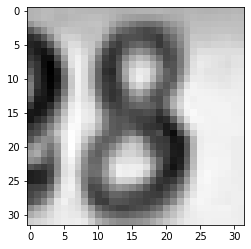

In [31]:
print("Label: {}".format(y_train[171]))
plt.imshow(X_train[171], cmap='gray');

#### 2. Reshape and normalize the train and test features so that the same can be fed for model building. We need to feed a 2D tensor into the model and currently we have a 3D tensor.

In [32]:
X_train = X_train.reshape(42000, 32*32)
print("Shape of X_train after reshaping:", X_train.shape)
X_test = X_test.reshape(18000, 32*32)
print("Shape of X_test after reshaping:", X_test.shape)

Shape of X_train after reshaping: (42000, 1024)
Shape of X_test after reshaping: (18000, 1024)


After reshaping the data, the shape of train data is (42000, 1024) and of test data is (18000, 1024). Then, we will normalize the data. 

In [33]:
print("Max value of X_train:", X_train.max())
print("Max value of X_train:", X_train.min())
print("Min value of X_test:", X_test.max())
print("Min value of X_test:", X_test.min())

X_train = X_train / 255.0
X_test = X_test / 255.0

print("Max value of X_train after normalizing:", X_train.max())
print("Max value of X_train after normalizing:", X_train.min())
print("Min value of X_test after normalizing:", X_test.max())
print("Min value of X_test after normalizing:", X_test.min())


Max value of X_train: 254.9745
Max value of X_train: 0.0
Min value of X_test: 254.9745
Min value of X_test: 0.0
Max value of X_train after normalizing: 0.9999
Max value of X_train after normalizing: 0.0
Min value of X_test after normalizing: 0.9999
Min value of X_test after normalizing: 0.0


#### 3. One hot encode the labels for train and test data

We will transform labels from a number to a vector with 1 on the label place and 0 on others. 

In [34]:
print('Label before one-hot encoding:', y_train[171])
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
print('Label after one-hot encoding:', y_train[171])

Label before one-hot encoding: 8
Label after one-hot encoding: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


Let's look at images and their labels to make sure that all transformations didn't corrupt our data. 

label for each of the below image: 2
label for each of the below image: 6
label for each of the below image: 7
label for each of the below image: 4
label for each of the below image: 4
label for each of the below image: 0
label for each of the below image: 3
label for each of the below image: 0
label for each of the below image: 7
label for each of the below image: 3


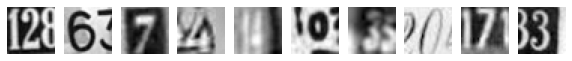

In [35]:
plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i].reshape(32, 32), cmap="gray")
    plt.axis('off')
    print('label for each of the below image: %s' % (np.argmax(y_train[0:10][i])))
plt.show();

Everything looks fine. Let's proceed to the next question.


#### 4. Define the model architecture using TensorFlow with a flatten layer followed by dense layers with activation as ReLu and softmax

We will use Sequential model with Flatten layer, two Dense layers with ReLu activation and 256 neurons followed by Dense layer with Softmax activation and L2 Regularization. 

In [37]:
hidden_nodes = 256
output_nodes = 10
Lambda = 0.0001
model = Sequential()
model.add(Flatten())
model.add(Dense(hidden_nodes, input_shape=(784,), activation='relu'))
model.add(Dense(hidden_nodes, activation='relu'))
model.add(Dense(output_nodes, activation='softmax', kernel_regularizer=regularizers.l2(Lambda)))
model.layers

#### 5. Compile the model with loss as categorical cross-entropy and adam optimizers. Use accuracy as the metric for evaluation
We will use Adam optimizer with custom learning rate that we will find out during parameter tuning and Categorical cross-entropy. 

In [40]:
learning_rate = 0.001
adam = optimizers.Adam(learning_rate=learning_rate, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.fit(X_train, y_train, validation_data = (X_test, y_test),
          epochs=1, batch_size=1000, verbose= 1)
model.summary()

42/42 [==============================] - 2s 37ms/step - loss: 2.3056 - accuracy: 0.1293 - val_loss: 2.2567 - val_accuracy: 0.1656
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (1000, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (1000, 256)               262400    
_________________________________________________________________
dense_13 (Dense)             (1000, 256)               65792     
_________________________________________________________________
dense_14 (Dense)             (1000, 10)                2570      
Total params: 330,762
Trainable params: 330,762
Non-trainable params: 0
_________________________________________________________________


#### 6. Fit and evaluate the model. Print the loss and accuracy for the test data

Let's define function that will help us to perform model tuning.

In [ ]:
def train_and_test_loop(iterations, lr, Lambda, verb=False, 
                        train_data = (X_train, y_train),
                        test_data = (X_test, y_test)):

    iterations = iterations
    learning_rate = lr
    hidden_nodes = 256
    output_nodes = 10
        
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(hidden_nodes, input_shape=(784,), activation='relu'))
    model.add(Dense(hidden_nodes, activation='relu'))
    model.add(Dense(output_nodes, activation='softmax', kernel_regularizer=regularizers.l2(Lambda)))
    
    adam = optimizers.Adam(lr=learning_rate, decay=1e-6)

    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    model.fit(train_data[0], train_data[1], validation_data = test_data,
              epochs=iterations, batch_size=1000, verbose= 1)
    train_score = model.evaluate(train_data[0], train_data[1], verbose=0)
    test_score = model.evaluate(test_data[0], test_data[1], verbose=0)
    if verb:
      return train_score, test_score

We will check the reasonability of the loss.

In [ ]:
lr = 0.00001
Lambda = 0
train_and_test_loop(1, lr, Lambda)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


42/42 [==============================] - 1s 15ms/step - loss: 2.3136 - accuracy: 0.1072 - val_loss: 2.3055 - val_accuracy: 0.1029


The loss is equal to -ln(0.1) and the accuracy of 9.8%. These values make sense for untrained models.
Let's check model with high lambda.

In [ ]:
lr = 0.00001
Lambda = 1e3
train_and_test_loop(1, lr, Lambda)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


42/42 [==============================] - 1s 18ms/step - loss: 19030.1250 - accuracy: 0.0966 - val_loss: 18948.0801 - val_accuracy: 0.0956


The loss is huge, as it should have been. 
Let's find out if our model can overfit a small subset to check the model's capacity.

In [41]:
X_train_subset = X_train[0:20].copy()
y_train_subset = y_train[0:20].copy()
print("Shapes of data subset:", X_train_subset.shape, y_train_subset.shape )

Shapes of data subset: (20, 1024) (20, 10)


In [ ]:
lr = 0.001
Lambda = 0
train_and_test_loop(50, lr, Lambda, train_data=(X_train_subset, y_train_subset))

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


1/1 [==============================] - 1s 853ms/step - loss: 2.3780 - accuracy: 0.0000e+00 - val_loss: 2.6676 - val_accuracy: 0.1004
Epoch 2/50
1/1 [==============================] - 0s 83ms/step - loss: 1.9364 - accuracy: 0.2500 - val_loss: 2.7713 - val_accuracy: 0.1016
Epoch 3/50
1/1 [==============================] - 0s 87ms/step - loss: 1.8126 - accuracy: 0.3000 - val_loss: 2.9652 - val_accuracy: 0.1015
Epoch 4/50
1/1 [==============================] - 0s 96ms/step - loss: 1.7533 - accuracy: 0.3000 - val_loss: 3.0599 - val_accuracy: 0.1017
Epoch 5/50
1/1 [==============================] - 0s 86ms/step - loss: 1.6679 - accuracy: 0.2500 - val_loss: 3.0907 - val_accuracy: 0.0992
Epoch 6/50
1/1 [==============================] - 0s 94ms/step - loss: 1.6242 - accuracy: 0.3500 - val_loss: 3.0954 - val_accuracy: 0.0982
Epoch 7/50
1/1 [==============================] - 0s 87ms/step - loss: 1.5351 - accuracy: 0.4000 - val_loss: 3.1691 - val_accuracy: 0.1051
Epoch 8/50
1/1 [=================

The loss is very small and accuracy is 100%. Therefore, the model has enough capacity for our task. Let's proceed to parameter tuning.

In [ ]:
lr = 1e-7
Lambda = 1e-7
train_and_test_loop(20, lr, Lambda)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
42/42 [==============================] - 1s 16ms/step - loss: 2.3496 - accuracy: 0.0926 - val_loss: 2.3493 - val_accuracy: 0.0943
Epoch 2/20
42/42 [==============================] - 0s 9ms/step - loss: 2.3487 - accuracy: 0.0928 - val_loss: 2.3484 - val_accuracy: 0.0942
Epoch 3/20
42/42 [==============================] - 0s 8ms/step - loss: 2.3477 - accuracy: 0.0927 - val_loss: 2.3474 - val_accuracy: 0.0937
Epoch 4/20
42/42 [==============================] - 0s 9ms/step - loss: 2.3467 - accuracy: 0.0926 - val_loss: 2.3465 - val_accuracy: 0.0938
Epoch 5/20
42/42 [==============================] - 0s 8ms/step - loss: 2.3458 - accuracy: 0.0924 - val_loss: 2.3455 - val_accuracy: 0.0938
Epoch 6/20
42/42 [==============================] - 0s 9ms/step - loss: 2.3449 - accuracy: 0.0925 - val_loss: 2.3446 - val_accuracy: 0.0937
Epoch 7/20
42/42 [==============================] - 0s 8ms/step - loss: 2.3440 - accuracy: 0.0925 - val_loss: 2.3437 - val_accuracy: 0.0935
Epoch 8/20
42/42 [=

The learning rate is too low, let's try 100. 

In [ ]:
lr = 1e2
Lambda = 1e-7
train_and_test_loop(20, lr, Lambda)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
42/42 [==============================] - 1s 13ms/step - loss: 48802529280.0000 - accuracy: 0.0997 - val_loss: 620.6690 - val_accuracy: 0.0982
Epoch 2/20
42/42 [==============================] - 0s 9ms/step - loss: 329.6830 - accuracy: 0.0996 - val_loss: 237.2520 - val_accuracy: 0.1002
Epoch 3/20
42/42 [==============================] - 0s 8ms/step - loss: 156.5324 - accuracy: 0.1040 - val_loss: 140.8765 - val_accuracy: 0.1016
Epoch 4/20
42/42 [==============================] - 0s 8ms/step - loss: 150.2257 - accuracy: 0.1021 - val_loss: 139.8075 - val_accuracy: 0.1002
Epoch 5/20
42/42 [==============================] - 0s 9ms/step - loss: 155.7881 - accuracy: 0.0990 - val_loss: 158.7790 - val_accuracy: 0.0982
Epoch 6/20
42/42 [==============================] - 0s 9ms/step - loss: 160.0633 - accuracy: 0.1000 - val_loss: 142.7013 - val_accuracy: 0.0955
Epoch 7/20
42/42 [==============================] - 0s 9ms/step - loss: 150.8035 - accuracy: 0.0995 - val_loss: 148.5741 - val_

This learning rate is too large. Let's iterate over various parameters where learning rate from 10^-7 to 100 and lambda from 10^-7 to 10^-2. 

In [ ]:
import math
train_test_info = []
for k in range(1,11):
    lr = math.pow(10, np.random.uniform(-7.0, 2.0))
    Lambda = math.pow(10, np.random.uniform(-7,-2))
    train, test = train_and_test_loop(100, lr, Lambda, verb=True)
    train_test_info.append([train, test, lr, Lambda])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
42/42 [==============================] - 1s 14ms/step - loss: 2.2872 - accuracy: 0.1424 - val_loss: 2.2397 - val_accuracy: 0.1944
Epoch 2/100
42/42 [==============================] - 0s 11ms/step - loss: 2.1408 - accuracy: 0.3194 - val_loss: 2.0002 - val_accuracy: 0.4105
Epoch 3/100
42/42 [==============================] - 0s 8ms/step - loss: 1.8237 - accuracy: 0.4668 - val_loss: 1.6442 - val_accuracy: 0.5162
Epoch 4/100
42/42 [==============================] - 0s 8ms/step - loss: 1.5368 - accuracy: 0.5433 - val_loss: 1.4138 - val_accuracy: 0.5942
Epoch 5/100
42/42 [==============================] - 0s 9ms/step - loss: 1.3618 - accuracy: 0.6004 - val_loss: 1.2856 - val_accuracy: 0.6233
Epoch 6/100
42/42 [==============================] - 0s 9ms/step - loss: 1.2611 - accuracy: 0.6265 - val_loss: 1.2127 - val_accuracy: 0.6392
Epoch 7/100
42/42 [==============================] - 0s 8ms/step - loss: 1.1806 - accuracy: 0.6504 - val_loss: 1.1503 - val_accuracy: 0.6542
Epoch 8/100

In [ ]:
for i in range(10):
  print("For lr: {} and lambda: {}, train: {}, test: {}".format(train_test_info[i][2], train_test_info[i][3], train_test_info[i][0], train_test_info[i][1]))

For lr: 0.0005077879572251674 and lambda: 1.1783426085477686e-07, train: [0.40435361862182617, 0.8802381157875061], test: [0.6090302467346191, 0.8317777514457703]
For lr: 0.028804060834430652 and lambda: 6.633186475540879e-05, train: [2.304403305053711, 0.10076190531253815], test: [2.305062770843506, 0.09822222590446472]
For lr: 1.8472782080826136e-07 and lambda: 1.1359519764478158e-06, train: [2.29764461517334, 0.12240476161241531], test: [2.299224615097046, 0.11883333325386047]
For lr: 0.0007074238211440991 and lambda: 0.0034329944628354553, train: [0.5302606225013733, 0.8631666898727417], test: [0.6702946424484253, 0.8263333439826965]
For lr: 2.0328971723421215e-07 and lambda: 2.8635496932761465e-07, train: [2.293678045272827, 0.13438095152378082], test: [2.2941293716430664, 0.1298888921737671]
For lr: 6.017946081464803 and lambda: 2.0964142401529473e-05, train: [44.800994873046875, 0.09971428662538528], test: [44.78578567504883, 0.10066666454076767]
For lr: 0.0006008997973192106 an

As we can see good learning rate has to be greater than 2*10^-4. Let's proceed with learning rate from 10^-5 to 0 and lambda from 10^-5 to 0. 

In [ ]:
import math
train_test_info = []
for k in range(20):
    lr = math.pow(10, np.random.uniform(-5.0, 0))
    Lambda = math.pow(10, np.random.uniform(-5, 0))
    train, test = train_and_test_loop(200, lr, Lambda, verb=True)
    train_test_info.append([train, test, lr, Lambda])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Выходные данные были обрезаны до нескольких последних строк (5000).
42/42 [==============================] - 0s 10ms/step - loss: 1.0154 - accuracy: 0.7246 - val_loss: 1.0361 - val_accuracy: 0.7194
Epoch 102/200
42/42 [==============================] - 0s 9ms/step - loss: 1.0129 - accuracy: 0.7261 - val_loss: 1.0329 - val_accuracy: 0.7185
Epoch 103/200
42/42 [==============================] - 1s 12ms/step - loss: 1.0092 - accuracy: 0.7275 - val_loss: 1.0285 - val_accuracy: 0.7197
Epoch 104/200
42/42 [==============================] - 0s 10ms/step - loss: 1.0052 - accuracy: 0.7287 - val_loss: 1.0244 - val_accuracy: 0.7206
Epoch 105/200
42/42 [==============================] - 0s 10ms/step - loss: 1.0018 - accuracy: 0.7290 - val_loss: 1.0217 - val_accuracy: 0.7218
Epoch 106/200
42/42 [==============================] - 0s 10ms/step - loss: 0.9995 - accuracy: 0.7279 - val_loss: 1.0207 - val_accuracy: 0.7212
Epoch 107/200
42/42 [==============================] - 0s 11ms/step - loss: 0.9969 

In [ ]:
for i in range(20):
  print("For lr: {} and lambda: {}, train: {}, test: {}".format(
      train_test_info[i][2], train_test_info[i][3], train_test_info[i][0],
      train_test_info[i][1]))

For lr: 0.751295041924964 and lambda: 0.6502990353517755, train: [2.317380666732788, 0.09971428662538528], test: [2.3170552253723145, 0.10066666454076767]
For lr: 0.0938757472548549 and lambda: 0.00016471756518801338, train: [2.3052759170532227, 0.09990476071834564], test: [2.3054041862487793, 0.10022222250699997]
For lr: 0.6354820610072959 and lambda: 0.041777624549540274, train: [2.3155338764190674, 0.10192856937646866], test: [2.316803216934204, 0.09549999982118607]
For lr: 0.04587467597032079 and lambda: 0.0014501895092437682, train: [2.3028650283813477, 0.09971428662538528], test: [2.303173065185547, 0.10066666454076767]
For lr: 0.0006643080212631481 and lambda: 0.0010730281237772874, train: [0.3336057662963867, 0.9177619218826294], test: [0.6109845638275146, 0.8444444537162781]
For lr: 0.07728292382668929 and lambda: 0.20816846881884318, train: [2.304064989089966, 0.10192856937646866], test: [2.304659843444824, 0.09549999982118607]
For lr: 0.0017022340365298416 and lambda: 0.8469

After this iteration we can see that the optimal range for learning rate from 2*10^-4 to 10^-2 and for lambda range is from 10^-5 to 10^-3.

In [ ]:
import math
train_test_info = []
for k in range(20):
    lr = 2*math.pow(10, np.random.uniform(-4.0, -2))
    Lambda = math.pow(10, np.random.uniform(-5, -3))
    train, test = train_and_test_loop(200, lr, Lambda, verb=True)
    train_test_info.append([train, test, lr, Lambda])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Выходные данные были обрезаны до нескольких последних строк (5000).
42/42 [==============================] - 0s 10ms/step - loss: 0.3830 - accuracy: 0.8861 - val_loss: 0.5924 - val_accuracy: 0.8347
Epoch 102/200
42/42 [==============================] - 0s 11ms/step - loss: 0.3812 - accuracy: 0.8872 - val_loss: 0.6011 - val_accuracy: 0.8334
Epoch 103/200
42/42 [==============================] - 0s 10ms/step - loss: 0.3837 - accuracy: 0.8853 - val_loss: 0.6312 - val_accuracy: 0.8259
Epoch 104/200
42/42 [==============================] - 0s 11ms/step - loss: 0.3787 - accuracy: 0.8878 - val_loss: 0.6272 - val_accuracy: 0.8272
Epoch 105/200
42/42 [==============================] - 0s 10ms/step - loss: 0.3742 - accuracy: 0.8882 - val_loss: 0.6049 - val_accuracy: 0.8342
Epoch 106/200
42/42 [==============================] - 0s 11ms/step - loss: 0.3619 - accuracy: 0.8941 - val_loss: 0.5963 - val_accuracy: 0.8378
Epoch 107/200
42/42 [==============================] - 0s 11ms/step - loss: 0.3675

In [ ]:
for i in range(20):
  print("For lr: {} and lambda: {}, train: {}, test: {}".format(
      train_test_info[i][2], train_test_info[i][3], train_test_info[i][0],
      train_test_info[i][1]))

For lr: 0.0003556560663920678 and lambda: 1.9312252052507715e-05, train: [0.2952519655227661, 0.9122856855392456], test: [0.6210815906524658, 0.836555540561676]
For lr: 0.001156046464028278 and lambda: 1.566688646605381e-05, train: [0.22984139621257782, 0.93278568983078], test: [0.6390163898468018, 0.8433889150619507]
For lr: 0.0038517024949206082 and lambda: 2.500435311572797e-05, train: [0.3484291732311249, 0.890999972820282], test: [0.6880503296852112, 0.8256666660308838]
For lr: 0.0008430360525293402 and lambda: 0.0001423804804101293, train: [0.2674552798271179, 0.9299047589302063], test: [0.6312161087989807, 0.8447777628898621]
For lr: 0.0008564808961011496 and lambda: 0.0005168214749772699, train: [0.31536731123924255, 0.918833315372467], test: [0.6154199242591858, 0.8496111035346985]
For lr: 0.0142279333450107 and lambda: 0.0001065561157870729, train: [2.3026669025421143, 0.09966666996479034], test: [2.302583694458008, 0.1007777750492096]
For lr: 0.007189546074073457 and lambda:

The best model is for lr = 0.001, lambda = 0.00002.

In [ ]:
hidden_nodes = 256
output_nodes = 10
        
model = Sequential()
model.add(Flatten())
model.add(Dense(hidden_nodes, input_shape=(784,), activation='relu'))
model.add(Dense(hidden_nodes, activation='relu'))
model.add(Dense(output_nodes, activation='softmax', kernel_regularizer=regularizers.l2(0.00002)))
    
adam = optimizers.Adam(lr=0.001, decay=1e-6)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data = (X_test, y_test),
          epochs=200, batch_size=1000, verbose= 1)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
42/42 [==============================] - 1s 13ms/step - loss: 2.3182 - accuracy: 0.1034 - val_loss: 2.2960 - val_accuracy: 0.1134
Epoch 2/200
42/42 [==============================] - 0s 8ms/step - loss: 2.2653 - accuracy: 0.1644 - val_loss: 2.2023 - val_accuracy: 0.2445
Epoch 3/200
42/42 [==============================] - 0s 8ms/step - loss: 2.0768 - accuracy: 0.3017 - val_loss: 1.9146 - val_accuracy: 0.3852
Epoch 4/200
42/42 [==============================] - 0s 8ms/step - loss: 1.7525 - accuracy: 0.4552 - val_loss: 1.5680 - val_accuracy: 0.5236
Epoch 5/200
42/42 [==============================] - 0s 9ms/step - loss: 1.4777 - accuracy: 0.5460 - val_loss: 1.3903 - val_accuracy: 0.5623
Epoch 6/200
42/42 [==============================] - 0s 9ms/step - loss: 1.3161 - accuracy: 0.5971 - val_loss: 1.2761 - val_accuracy: 0.6064
Epoch 7/200
42/42 [==============================] - 0s 9ms/step - loss: 1.2170 - accuracy: 0.6271 - val_loss: 1.1797 - val_accuracy: 0.6489
Epoch 8/200


#### 7. Plot the training loss, validation loss vs number of epochs and training accuracy, validation accuracy vs number of epochs plot and write your observations on the same.
We will check optimal numbers of epochs with plots. 

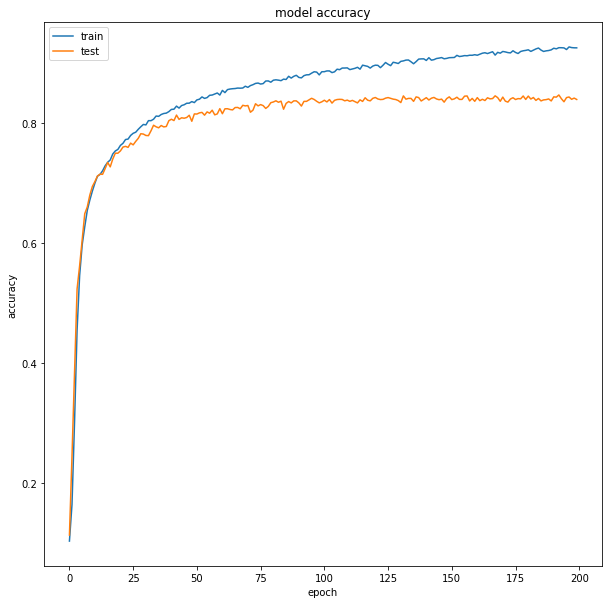

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show();

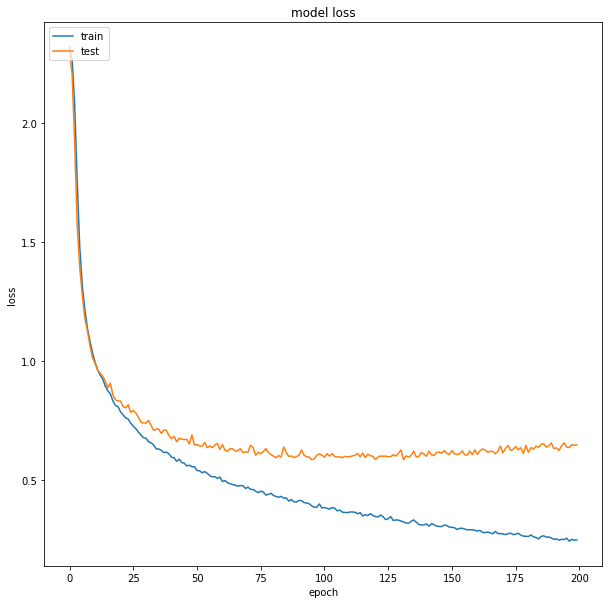

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show();

As we can see from the plots the optimal value for epochs is 150.

In [45]:
hidden_nodes = 256
output_nodes = 10
        
model = Sequential()
model.add(Flatten())
model.add(Dense(hidden_nodes, input_shape=(784,), activation='relu'))
model.add(Dense(hidden_nodes, activation='relu'))
model.add(Dense(output_nodes, activation='softmax', kernel_regularizer=regularizers.l2(0.00002)))
    
adam = optimizers.Adam(lr=0.001, decay=1e-6)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data = (X_test, y_test),
          epochs=100, batch_size=1000, verbose= 1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
42/42 [==============================] - 2s 36ms/step - loss: 2.3076 - accuracy: 0.1206 - val_loss: 2.2681 - val_accuracy: 0.1567
Epoch 2/100
42/42 [==============================] - 1s 33ms/step - loss: 2.1757 - accuracy: 0.2463 - val_loss: 2.0448 - val_accuracy: 0.2958
Epoch 3/100
42/42 [==============================] - 1s 34ms/step - loss: 1.8541 - accuracy: 0.4055 - val_loss: 1.6757 - val_accuracy: 0.4637
Epoch 4/100
42/42 [==============================] - 1s 33ms/step - loss: 1.5415 - accuracy: 0.5241 - val_loss: 1.4125 - val_accuracy: 0.5832
Epoch 5/100
42/42 [==============================] - 1s 32ms/step - loss: 1.3416 - accuracy: 0.5941 - val_loss: 1.2505 - val_accuracy: 0.6252
Epoch 6/100
42/42 [==============================] - 1s 33ms/step - loss: 1.2319 - accuracy: 0.6276 - val_loss: 1.1759 - val_accuracy: 0.6443
Epoch 7/100
42/42 [==============================] - 1s 33ms/step - loss: 1.1514 - accuracy: 0.6514 - val_loss: 1.1380 - val_accuracy: 0.6516
Epoch 

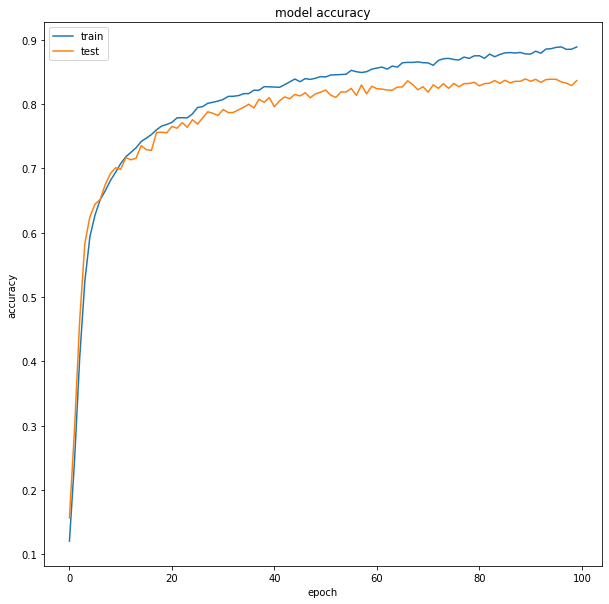

In [46]:
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show();

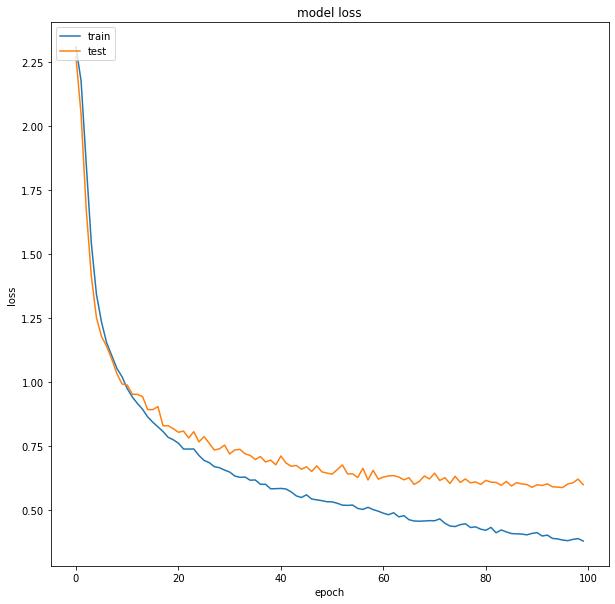

In [47]:
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show();

From the plot of accuracy, we can see that the model shouldn't continue training, because validation accuracy stopped growing. We can also see that the model has not yet over-learned the training dataset, showing comparable skill on both datasets. From the plot of loss, we can see that the model has comparable performance on both train and validation datasets. If these parallel plots start to depart consistently, it might be a sign to stop training at an earlier epoch.